<a href="https://colab.research.google.com/github/osun24/nsclc-adj-chemo/blob/main/2026_TorchSurv_DeepSurv_with_Optuna_Single_Objective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary packages
!pip install torchsurv scikit-survival
!pip install optuna optuna-dashboard scikit-survival portpicker lifelines

# Import required packages
import os
import time
import datetime
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sksurv.metrics import concordance_index_censored

# (Optional) Mount Google Drive if you plan to load/save files there
from google.colab import drive
drive.mount('/content/drive')

from optuna_dashboard import run_server
import threading, time, portpicker
from google.colab import output

PORT = portpicker.pick_unused_port()

def _serve():
    run_server("sqlite:///deepsurv_optuna.db", host="0.0.0.0", port=PORT)

threading.Thread(target=_serve, daemon=True).start()
time.sleep(2)
print("Dashboard:", output.eval_js(f"google.colab.kernel.proxyPort({PORT}, {{'cache': false}})"))


ValueError: mount failed

In [ ]:
# ============================================================
# Colab-ready SINGLE CELL
# DeepSurv + Multi-Objective Optuna (Val CI ↑, Gap ↓, Params ↓)
# with capacity budgets, conservative Pareto selector, column-dropout,
# grouped L1 (stronger on interactions), and WD applied to last layer.
# ============================================================

# ---------- Installs (Colab) ----------
!pip -q install optuna optuna-dashboard scikit-survival portpicker

# ---------- (Optional) Mount Google Drive ----------
from google.colab import drive
drive.mount('/content/drive')

# ---------- Imports ----------
import os, math, copy, warnings, random, gc, time, threading
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler

# Prefer torchsurv if available; fallback to custom Efron
try:
    from torchsurv.loss.cox import neg_partial_log_likelihood
    _HAS_TORCHSURV = True
except Exception:
    _HAS_TORCHSURV = False

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis

import optuna
from optuna.samplers import NSGAIISampler

import portpicker
from google.colab import output

warnings.filterwarnings("ignore", message="Ties in event time detected; using efron's method to handle ties.")
torch.manual_seed(0); np.random.seed(0); random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Cox Losses
# ============================================================
def _cox_negloglik_efron(pred, event, time):
    eta = pred.reshape(-1)
    e = event.to(torch.float32).reshape(-1)
    t = time.reshape(-1)
    order = torch.argsort(t, descending=True)
    t = t[order]; e = e[order]; eta = eta[order]
    exp_eta = torch.exp(eta)
    cum_exp = torch.cumsum(exp_eta, dim=0)
    uniq_mask = torch.ones_like(t, dtype=torch.bool)
    uniq_mask[1:] = t[1:] != t[:-1]
    idxs = torch.nonzero(uniq_mask, as_tuple=False).reshape(-1)
    idxs = torch.cat([idxs, torch.tensor([len(t)], device=t.device)])
    nll = torch.tensor(0.0, device=t.device)
    for k in range(len(idxs)-1):
        start, end = idxs[k].item(), idxs[k+1].item()
        e_slice = e[start:end]
        d = int(e_slice.sum().item())
        if d == 0: continue
        eta_events = eta[start:end][e_slice.bool()]
        exp_events = torch.exp(eta[start:end])[e_slice.bool()]
        s_eta = eta_events.sum()
        risk_sum = cum_exp[end-1]
        s_exp = exp_events.sum()
        eps = 1e-12
        log_terms = 0.0
        for j in range(d):
            log_terms = log_terms + torch.log(risk_sum - (j / d) * s_exp + eps)
        nll = nll - (s_eta - log_terms)
    return nll / t.numel()

def cox_negloglik(pred, event, time):
    if _HAS_TORCHSURV:
        return neg_partial_log_likelihood(pred, event, time, reduction='mean')
    return _cox_negloglik_efron(pred, event, time)

# Weighted Breslow negative partial log-likelihood (IPTW)
def cox_negloglik_breslow_weighted(pred, event, time, weight=None):
    eta = pred.reshape(-1)
    e = event.to(torch.float32).reshape(-1)
    t = time.reshape(-1)
    if weight is None:
        weight = torch.ones_like(eta)
    else:
        weight = weight.reshape(-1)

    order = torch.argsort(t, descending=True)
    t = t[order]; e = e[order]; eta = eta[order]; w = weight[order]
    exp_eta = torch.exp(eta)
    w_exp = w * exp_eta
    cum_w_exp = torch.cumsum(w_exp, dim=0)

    uniq = torch.ones_like(t, dtype=torch.bool)
    uniq[1:] = t[1:] != t[:-1]
    idxs = torch.nonzero(uniq, as_tuple=False).reshape(-1)
    idxs = torch.cat([idxs, torch.tensor([len(t)], device=t.device)])

    nll = torch.tensor(0.0, device=t.device)
    eps = 1e-12
    for k in range(len(idxs)-1):
        s, eidx = idxs[k].item(), idxs[k+1].item()
        emask = e[s:eidx] > 0.5
        if emask.sum() == 0:
            continue
        w_events = w[s:eidx][emask]
        eta_events = eta[s:eidx][emask]
        s_eta = (w_events * eta_events).sum()
        denom = cum_w_exp[eidx-1]
        nll = nll - (s_eta - w_events.sum() * torch.log(denom + eps))
    return nll / (w.sum() + 1e-9)

def cox_loss(pred, event, time, weight=None):
    """Use weighted Breslow if weights provided; else Efron/torchsurv."""
    if weight is None:
        return cox_negloglik(pred, event, time)
    return cox_negloglik_breslow_weighted(pred, event, time, weight)

# ============================================================
# Model, Dataset (with weights), Sampler, Utils
# ============================================================
class DeepSurvMLP(nn.Module):
    def __init__(self, in_features, hidden_layers, dropout=0.0, activation=nn.ReLU()):
        super().__init__()
        layers, d = [], in_features
        for units in hidden_layers:
            layers += [nn.Linear(d, units), activation]
            if dropout > 0: layers.append(nn.Dropout(dropout))
            d = units
        layers.append(nn.Linear(d, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

class SurvivalDataset(Dataset):
    def __init__(self, features, time_vals, events, weights=None):
        self.x = torch.tensor(features, dtype=torch.float32)
        self.time = torch.tensor(time_vals, dtype=torch.float32)
        self.event = torch.tensor(events.astype(bool), dtype=torch.bool)
        if weights is None:
            self.w = torch.ones(len(self.x), dtype=torch.float32)
        else:
            self.w = torch.tensor(weights, dtype=torch.float32)
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.time[idx], self.event[idx], self.w[idx]

class EventBalancedBatchSampler(Sampler):
    def __init__(self, events_numpy, batch_size, seed=0):
        events = np.asarray(events_numpy).astype(bool)
        self.pos_idx = np.where(events)[0]
        self.neg_idx = np.where(~events)[0]
        assert len(self.pos_idx) > 0, "No events in training set — cannot balance batches."
        self.bs = int(batch_size)
        self.rng = np.random.default_rng(seed)
    def __iter__(self):
        pos = self.rng.permutation(self.pos_idx)
        neg = self.rng.permutation(self.neg_idx)
        n_total = len(pos) + len(neg)
        n_batches = math.ceil(n_total / self.bs)
        pi = ni = 0
        for _ in range(n_batches):
            take_pos = 1 if pi < len(pos) else 0
            avail_neg = max(0, len(neg) - ni)
            take_neg = min(self.bs - take_pos, avail_neg)
            need = self.bs - (take_pos + take_neg)
            extra_pos = min(need, max(0, len(pos) - (pi + take_pos)))
            take_pos += extra_pos
            batch = np.concatenate([pos[pi:pi+take_pos], neg[ni:ni+take_neg]])
            pi += take_pos; ni += take_neg
            if batch.size == 0: break
            self.rng.shuffle(batch)
            yield batch.tolist()
    def __len__(self):
        return math.ceil((len(self.pos_idx) + len(self.neg_idx)) / self.bs)

def make_optimizer_groups(model, lr, wd, apply_final_wd=True):
    # apply_final_wd now defaults to True
    linears = [m for m in model.modules() if isinstance(m, nn.Linear)]
    last_linear = linears[-1] if len(linears) > 0 else None
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad: continue
        if name.endswith('bias'):
            no_decay.append(p); continue
        if (last_linear is not None) and (p is last_linear.weight) and not apply_final_wd:
            no_decay.append(p); continue
        decay.append(p)
    return optim.AdamW(
        [{'params': decay, 'weight_decay': float(wd)},
         {'params': no_decay, 'weight_decay': 0.0}],
        lr=float(lr)
    )

def set_dropout_p(model, p):
    for m in model.modules():
        if isinstance(m, nn.Dropout): m.p = float(p)

def set_weight_decay(optimizer, wd):
    for g in optimizer.param_groups: g['weight_decay'] = float(wd)

def l1_penalty_first_layer(model):
    for m in model.modules():
        if isinstance(m, nn.Linear): return m.weight.abs().sum()
    return torch.tensor(0.0, device=next(model.parameters()).device)

# ---- NEW: grouped L1 that shrinks interaction columns more than mains
def l1_first_layer_grouped(model, inter_start_idx, lam_main=0.0, lam_inter=0.0):
    W = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            W = m.weight   # [hidden, in_dim]
            break
    if W is None or (lam_main == 0 and lam_inter == 0):
        return torch.tensor(0.0, device=next(model.parameters()).device)
    main_sum = W[:, :inter_start_idx].abs().sum()
    inter_sum = W[:, inter_start_idx:].abs().sum()
    return lam_main * main_sum + lam_inter * inter_sum

# ---- NEW: column-wise dropout (drop entire gene/interaction columns)
def column_dropout(x, p, col_start):
    """Drop whole columns from col_start onward with prob p (shared across batch)."""
    if p <= 0.0: return x
    keep = 1.0 - float(p)
    B, D = x.shape
    device = x.device
    if col_start >= D: return x
    # One Bernoulli per column, scale by 1/keep to keep expectation
    m = torch.bernoulli(torch.full((D - col_start,), keep, device=device)) / max(keep, 1e-6)
    x = x.clone()
    x[:, col_start:] = x[:, col_start:] * m
    return x

@torch.no_grad()
def evaluate_ci(model, dataloader, device):
    model.eval()
    preds, times, events = [], [], []
    for batch in dataloader:
        if len(batch) == 4:
            x, t, e, _ = batch
        else:
            x, t, e = batch
        y = torch.clamp(model(x.to(device)), -20, 20)
        preds.append(y.cpu().numpy().ravel())
        times.append(t.numpy()); events.append(e.numpy())
    preds = np.concatenate(preds)
    times = np.concatenate(times); events = np.concatenate(events)
    if np.isnan(preds).any(): return -np.inf
    return concordance_index_censored(events.astype(bool), times, preds)[0]

def evaluate_ci_grouped(model, X, t, e, group_mask):
    """Compute C-index within group_mask==1 and group_mask==0."""
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().ravel()
    res = {}
    for label, mask in [("ACT=1", group_mask.astype(bool)), ("ACT=0", ~group_mask.astype(bool))]:
        if mask.sum() >= 3:
            ci = concordance_index_censored(e[mask].astype(bool), t[mask], preds[mask])[0]
            res[label] = float(ci)
        else:
            res[label] = np.nan
    return res

# ============================================================
# Data loading & preprocessing
# ============================================================
TRAIN_CSV = "/content/drive/MyDrive/affyfRMATrain.csv"
VALID_CSV = "/content/drive/MyDrive/affyfRMAValidation.csv"
TEST_CSV  = "/content/drive/MyDrive/affyfRMATest.csv"

GENES_CSV = "/mnt/data/LOOCV_Genes2.csv"
if not os.path.exists(GENES_CSV):
    if os.path.exists("/content/LOOCV_Genes2.csv"):
        GENES_CSV = "/content/LOOCV_Genes2.csv"
    elif os.path.exists("/content/drive/MyDrive/LOOCV_Genes2.csv"):
        GENES_CSV = "/content/drive/MyDrive/LOOCV_Genes2.csv"
print("LOOCV_Genes2.csv path:", GENES_CSV)

CLINICAL_VARS = [
    "Adjuvant Chemo","Age","IS_MALE",
    "Stage_IA","Stage_IB","Stage_II","Stage_III",
    "Histology_Adenocarcinoma","Histology_Large Cell Carcinoma","Histology_Squamous Cell Carcinoma",
    "Race_African American","Race_Asian","Race_Caucasian","Race_Native Hawaiian or Other Pacific Islander","Race_Unknown",
    "Smoked?_No","Smoked?_Unknown","Smoked?_Yes"
]

def load_genes_list(genes_csv):
    g = pd.read_csv(genes_csv)
    if "Prop" not in g.columns or "Gene" not in g.columns:
        raise ValueError(f"LOOCV_Genes2.csv must have columns 'Gene' and 'Prop'. Found: {list(g.columns)}")
    g["Prop"] = pd.to_numeric(g["Prop"], errors="coerce").fillna(0)
    genes = g.loc[g["Prop"] == 1, "Gene"].astype(str).tolist()
    print(f"[Genes] Selected {len(genes)} genes with Prop == 1")
    return genes

def coerce_survival_cols(df):
    if df["OS_STATUS"].dtype == object:
        df["OS_STATUS"] = df["OS_STATUS"].replace({"DECEASED":1,"LIVING":0,"Dead":1,"Alive":0}).astype(int)
    else:
        df["OS_STATUS"] = pd.to_numeric(df["OS_STATUS"], errors="coerce").fillna(0).astype(int)
    df["OS_MONTHS"] = pd.to_numeric(df["OS_MONTHS"], errors="coerce").fillna(0.0).astype(float)
    return df

def preprocess_split(df, clinical_vars, gene_names):
    if "Adjuvant Chemo" in df.columns:
        df["Adjuvant Chemo"] = df["Adjuvant Chemo"].replace({"OBS":0, "ACT":1})
    for col in ["Adjuvant Chemo","IS_MALE"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
    df = coerce_survival_cols(df)
    keep_cols = [c for c in clinical_vars if c in df.columns] + [g for g in gene_names if g in df.columns]
    missing_clin = [c for c in clinical_vars if c not in df.columns]
    if missing_clin:
        print(f"[WARN] Missing clinical columns: {missing_clin}")
    cols = ["OS_STATUS","OS_MONTHS"] + keep_cols
    return df[cols].copy()

# Load CSVs
train_raw = pd.read_csv(TRAIN_CSV)
valid_raw = pd.read_csv(VALID_CSV)
test_raw  = pd.read_csv(TEST_CSV)

GENE_LIST = load_genes_list(GENES_CSV)

# Reduce to requested columns on each split
train_df = preprocess_split(train_raw, CLINICAL_VARS, GENE_LIST)
valid_df = preprocess_split(valid_raw, CLINICAL_VARS, GENE_LIST)
test_df  = preprocess_split(test_raw,  CLINICAL_VARS, GENE_LIST)

# Intersect features that exist everywhere
feat_candidates = [c for c in (CLINICAL_VARS + GENE_LIST)
                   if c in train_df.columns and c in valid_df.columns and c in test_df.columns]
CLIN_FEATS = [c for c in CLINICAL_VARS if c in feat_candidates]
GENE_FEATS = [g for g in GENE_LIST if g in feat_candidates]
CLIN_FEATS_PRETX = [c for c in CLIN_FEATS if c != "Adjuvant Chemo"]  # PS excludes treatment itself
print(f"[Features] Using {len(feat_candidates)} common features → Clinical={len(CLIN_FEATS)}, Genes={len(GENE_FEATS)}")

# Sort Train/Val by event time & status (desc)
train_df = train_df.sort_values(by=["OS_MONTHS","OS_STATUS"], ascending=[False, False]).reset_index(drop=True)
valid_df = valid_df.sort_values(by=["OS_MONTHS","OS_STATUS"], ascending=[False, False]).reset_index(drop=True)

# ---- Train-only gene ranking (univariate Cox CI on TRAIN) ----
def rank_genes_univariate(train_df, gene_cols):
    y = Surv.from_arrays(event=train_df["OS_STATUS"].astype(bool).values,
                         time=train_df["OS_MONTHS"].values.astype(float))
    ranks = []
    for g in gene_cols:
        Xg = train_df[[g]].to_numpy(dtype=np.float32)
        try:
            model = CoxPHSurvivalAnalysis(alpha=1e-12)
            model.fit(Xg, y)
            pred = model.predict(Xg)
            ci = concordance_index_censored(y["event"], y["time"], pred)[0]
            ranks.append((g, float(ci)))
        except Exception:
            ranks.append((g, 0.5))
    ranks.sort(key=lambda z: z[1], reverse=True)
    return [g for g, _ in ranks]

GENE_RANK = rank_genes_univariate(train_df, GENE_FEATS)
MAX_GENES = len(GENE_RANK)
print(f"[Gene Ranking] Ranked {MAX_GENES} genes on TRAIN")

# ============================================================
# Feature construction (main effects + interactions) & IPTW
# ============================================================
def build_features_with_interactions(df, main_genes, inter_genes, act_col="Adjuvant Chemo"):
    base_cols = CLIN_FEATS + list(main_genes)  # keep ACT main effect via CLIN_FEATS
    X_base = df[base_cols].to_numpy(dtype=np.float32)
    A = df[act_col].to_numpy(dtype=np.float32).reshape(-1, 1)
    if len(inter_genes) > 0:
        X_int = df[list(inter_genes)].to_numpy(dtype=np.float32) * A
        X = np.concatenate([X_base, X_int], axis=1)
        names = base_cols + [f"{g}*ACT" for g in inter_genes]
    else:
        X = X_base
        names = base_cols
    return X, names

def compute_iptw(df, covariate_cols, act_col="Adjuvant Chemo",
                 ps_clip=(0.05, 0.95), w_clip=(0.1, 10.0),
                 ref_prevalence=None, model=None):
    A = df[act_col].astype(int).values
    X = df[covariate_cols].astype(float).values
    if model is None:
        model = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")
        model.fit(X, A)
    ps = model.predict_proba(X)[:, 1]
    ps = np.clip(ps, ps_clip[0], ps_clip[1])
    if ref_prevalence is None:
        ref_prevalence = A.mean()
    w = np.where(A == 1, ref_prevalence / ps, (1 - ref_prevalence) / (1 - ps))
    w = np.clip(w, w_clip[0], w_clip[1])
    return w.astype(np.float32), model, float(ref_prevalence)

# ============================================================
# Training helpers (with input dropout/noise, weights, warm-ups)
# ============================================================
def _apply_input_dropout(x, p):
    if p <= 0.0: return x
    keep = 1.0 - p
    mask = torch.bernoulli(torch.full_like(x, keep))
    return x * mask / max(keep, 1e-6)

def train_one_epoch_reg(model, optimizer, dataloader, device,
                        l1_lambda=0.0, epoch=0, warmup_epochs=20,
                        input_dropout=0.0, noise_std=0.0, grad_clip=5.0,
                        col_dropout_p=0.0, col_start=0,
                        inter_start_idx=None, lam_main=0.0, lam_inter=0.0):
    model.train()
    warm = min(1.0, (epoch + 1) / float(warmup_epochs))
    loss_sum, w_sum = 0.0, 0.0
    for x, t, e, w in dataloader:
        if e.sum().item() == 0:
            continue
        x, t, e, w = x.to(device), t.to(device), e.to(device), w.to(device)
        if input_dropout > 0.0: x = _apply_input_dropout(x, input_dropout)
        if col_dropout_p > 0.0 and col_start > 0: x = column_dropout(x, col_dropout_p, col_start)
        if noise_std > 0.0: x = x + noise_std * torch.randn_like(x)
        optimizer.zero_grad(set_to_none=True)
        out = torch.clamp(model(x), -20, 20)
        loss = cox_loss(out, e, t, weight=w)
        if l1_lambda > 0:
            if inter_start_idx is None:
                loss = loss + (l1_lambda * warm) * l1_penalty_first_layer(model)
            else:
                loss = loss + (l1_lambda * warm) * l1_first_layer_grouped(model, inter_start_idx,
                                                                          lam_main=lam_main, lam_inter=lam_inter)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), float(grad_clip))
        optimizer.step()
        loss_sum += loss.item() * float(w.sum().item())
        w_sum += float(w.sum().item())
    return {'avg_loss': (loss_sum / max(w_sum, 1e-9)), 'warm': warm}

def full_risk_set_step_reg(model, optimizer, ds, device,
                           l1_lambda=0.0, warm=1.0,
                           input_dropout=0.0, noise_std=0.0, grad_clip=5.0,
                           col_dropout_p=0.0, col_start=0,
                           inter_start_idx=None, lam_main=0.0, lam_inter=0.0):
    model.train()
    X_all = ds.x.to(device); t_all = ds.time.to(device); e_all = ds.event.to(device); w_all = ds.w.to(device)
    XX = X_all
    if input_dropout > 0.0: XX = _apply_input_dropout(XX, input_dropout)
    if col_dropout_p > 0.0 and col_start > 0: XX = column_dropout(XX, col_dropout_p, col_start)
    if noise_std > 0.0: XX = XX + noise_std * torch.randn_like(XX)
    optimizer.zero_grad(set_to_none=True)
    out_all = torch.clamp(model(XX), -20, 20)
    loss_full = cox_loss(out_all, e_all, t_all, weight=w_all)
    if l1_lambda > 0:
        if inter_start_idx is None:
            loss_full = loss_full + (l1_lambda * warm) * l1_penalty_first_layer(model)
        else:
            loss_full = loss_full + (l1_lambda * warm) * l1_first_layer_grouped(model, inter_start_idx,
                                                                                lam_main=lam_main, lam_inter=lam_inter)
    loss_full.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), float(grad_clip))
    optimizer.step()
    return float(loss_full.detach().cpu().item())

def count_params(in_dim, layers):
    params, d = 0, in_dim
    for h in layers:
        params += d*h + h
        d = h
    params += d*1 + 1
    return int(params)
# ============================================================
# Optuna: Single-Objective (Val CI ↑ only)
# + Budgets (feature + params)
# ============================================================

ARCH_CHOICES = ("16","32","64","32-16","64-32","64-64")
def layers_from_arch(arch_str: str):
    return [int(x) for x in arch_str.split("-") if x.strip()]

def suggest_hparams(trial):
    base_main  = [16, 32, 64, 96, 128, 192, 256, 384, 512, 800, MAX_GENES]
    TOPK_MAIN_CHOICES = tuple(sorted({k for k in base_main if k <= MAX_GENES}))
    top_k_genes = trial.suggest_categorical("top_k_genes", TOPK_MAIN_CHOICES)

    base_inter = [0, 8, 16, 32, 64, 96, 128, 256, 512]
    TOPK_INTER_CHOICES = tuple(sorted({k for k in base_inter if k <= MAX_GENES}))
    top_k_inter_raw = trial.suggest_categorical("top_k_inter", TOPK_INTER_CHOICES)

    arch = trial.suggest_categorical("arch", ARCH_CHOICES)
    dropout = trial.suggest_float("dropout", 0.10, 0.50)
    input_dropout = trial.suggest_float("input_dropout", 0.00, 0.15)
    noise_std = trial.suggest_float("noise_std", 0.0, 0.08)

    wd = trial.suggest_float("wd", 1e-6, 3e-3, log=True)
    use_l1 = trial.suggest_categorical("use_l1", (0, 1))
    l1 = 0.0 if use_l1 == 0 else trial.suggest_float("l1", 1e-7, 1e-3, log=True)

    lr = trial.suggest_float("lr", 1e-5, 4e-4, log=True)
    sched = trial.suggest_categorical("sched", ("cosine", "cawr", "none"))
    if sched == "cawr":
        cawr_T0 = trial.suggest_int("cawr_T0", 16, 72, step=8)
        cawr_Tmult = trial.suggest_categorical("cawr_Tmult", (1, 2, 3))
    else:
        cawr_T0 = cawr_Tmult = None

    epochs = trial.suggest_int("epochs", 96, 256, step=32)
    batch_size = trial.suggest_categorical("batch_size", (32, 64, 128))
    grad_clip = trial.suggest_float("grad_clip", 2.0, 9.0)

    top_k_inter = int(min(top_k_inter_raw, top_k_genes))

    return dict(
        arch=arch, top_k_genes=int(top_k_genes), top_k_inter=int(top_k_inter),
        dropout=dropout, input_dropout=input_dropout, noise_std=noise_std,
        wd=wd, apply_final_wd=1,
        use_l1=int(use_l1), l1=float(l1),
        lr=lr, sched=sched, cawr_T0=cawr_T0, cawr_Tmult=cawr_Tmult,
        epochs=int(epochs), batch_size=int(batch_size), grad_clip=float(grad_clip)
    )

# Warm-ups and caps
MAX_EPOCHS_CAP = 256
WARMUP_EPOCHS_L1 = 20
WARMUP_EPOCHS_DROPOUT = 20
WARMUP_EPOCHS_WD = 20
DROPOUT_START = 0.10
WD_START = 0.0

# ====== NEW: capacity budgets tied to sample size ======
N_EVENTS_TR = int(train_df["OS_STATUS"].sum())
FEAT_EVENT_FRACTION = 0.50         # tune 0.35–0.60
FEAT_BUDGET = max(24, int(FEAT_EVENT_FRACTION * N_EVENTS_TR))   # total inputs incl. clinical
PARAM_BUDGET = 120_000             # cap total parameters; tune 80k–150k
print(f"[Budgets] events(train)={N_EVENTS_TR} → feature budget≤{FEAT_BUDGET} total inputs, param budget≤{PARAM_BUDGET:,}")

# Column-dropout prob (genes + interactions). Keep moderate.
COL_DROPOUT_P = 0.30
# Grouped L1 strength split (interactions shrunk more than mains)
L1_LAM_MAIN = 0.2
L1_LAM_INTER = 1.0

def objective(trial):
    hp = suggest_hparams(trial)
    layers = layers_from_arch(hp["arch"])

    # --- Trial-specific features (main + interactions) with budgets
    MAX_NONCLIN = max(8, FEAT_BUDGET - len(CLIN_FEATS))
    k_main = int(min(hp["top_k_genes"], MAX_NONCLIN))
    k_int  = int(min(hp["top_k_inter"], k_main, MAX_NONCLIN - k_main))

    genes_main  = GENE_RANK[:k_main]
    genes_inter = genes_main[:k_int]

    Xtr_raw, feat_names = build_features_with_interactions(train_df, genes_main, genes_inter, act_col="Adjuvant Chemo")
    Xva_raw, _          = build_features_with_interactions(valid_df, genes_main, genes_inter, act_col="Adjuvant Chemo")

    # If params exceed cap, shrink interactions first, then mains
    in_dim_trial = Xtr_raw.shape[1]
    while count_params(in_dim_trial, layers) > PARAM_BUDGET and (k_int > 0 or k_main > 8):
        if k_int > 0:
            k_int = max(0, k_int // 2)
        else:
            k_main = max(8, int(k_main * 0.8))
        genes_main  = GENE_RANK[:k_main]
        genes_inter = genes_main[:min(k_int, k_main, MAX_NONCLIN - k_main)]
        Xtr_raw, feat_names = build_features_with_interactions(train_df, genes_main, genes_inter, act_col="Adjuvant Chemo")
        Xva_raw, _          = build_features_with_interactions(valid_df, genes_main, genes_inter, act_col="Adjuvant Chemo")
        in_dim_trial = Xtr_raw.shape[1]

    # --- TRAIN-only impute & standardize
    med = np.nanmedian(Xtr_raw, axis=0)
    Xtr = np.where(np.isnan(Xtr_raw), med, Xtr_raw)
    Xva = np.where(np.isnan(Xva_raw), med, Xva_raw)
    sc = StandardScaler().fit(Xtr)
    Xtr = sc.transform(Xtr).astype(np.float32)
    Xva = sc.transform(Xva).astype(np.float32)

    ytr_t = train_df["OS_MONTHS"].to_numpy(np.float32)
    ytr_e = train_df["OS_STATUS"].to_numpy(int)
    yva_t = valid_df["OS_MONTHS"].to_numpy(np.float32)
    yva_e = valid_df["OS_STATUS"].to_numpy(int)

    # --- IPTW (train model, apply to val)
    w_tr, ps_model, pi_tr = compute_iptw(train_df, covariate_cols=CLIN_FEATS_PRETX, act_col="Adjuvant Chemo")
    w_va, _, _ = compute_iptw(valid_df, covariate_cols=CLIN_FEATS_PRETX, act_col="Adjuvant Chemo",
                              ref_prevalence=pi_tr, model=ps_model)

    # --- Datasets/loaders
    bs = hp["batch_size"]
    tr_ds = SurvivalDataset(Xtr, ytr_t, ytr_e, weights=w_tr)
    va_ds = SurvivalDataset(Xva, yva_t, yva_e, weights=w_va)
    tr_sampler = EventBalancedBatchSampler(ytr_e, bs, seed=42)
    tr_loader = DataLoader(tr_ds, batch_sampler=tr_sampler, num_workers=0)
    tr_eval_loader = DataLoader(tr_ds, batch_size=bs, shuffle=False, num_workers=0)
    va_loader = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=0)

    # --- Model/opt/sched
    in_dim_trial = Xtr.shape[1]
    model = DeepSurvMLP(in_dim_trial, layers, dropout=hp["dropout"]).to(device)
    opt = make_optimizer_groups(model, lr=hp["lr"], wd=hp["wd"], apply_final_wd=True)

    epochs = int(min(hp["epochs"], MAX_EPOCHS_CAP))
    if hp["sched"] == "cosine":
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        def sched_step(i): sched.step()
    elif hp["sched"] == "cawr":
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=int(hp["cawr_T0"]), T_mult=int(hp["cawr_Tmult"]))
        def sched_step(i): sched.step(i+1)
    else:
        sched = None
        def sched_step(i): pass

    # --- Early-stopping on Val CI
    PATIENCE = 16
    MIN_DELTA = 1e-4
    no_improve = 0
    best_val_ci = -np.inf
    best_epoch = 0

    col_start = len(CLIN_FEATS)
    inter_start_idx = len(CLIN_FEATS) + k_main

    for ep in range(epochs):
        frac_d = min(1.0, ep / float(WARMUP_EPOCHS_DROPOUT))
        frac_w = min(1.0, ep / float(WARMUP_EPOCHS_WD))
        set_dropout_p(model, DROPOUT_START + (hp['dropout'] - DROPOUT_START) * frac_d)
        set_weight_decay(opt, WD_START + (hp['wd'] - WD_START) * frac_w)

        st = train_one_epoch_reg(
            model, opt, tr_loader, device,
            l1_lambda=float(hp.get("l1", 0.0)), epoch=ep, warmup_epochs=WARMUP_EPOCHS_L1,
            input_dropout=float(hp.get("input_dropout", 0.0)),
            noise_std=float(hp.get("noise_std", 0.0)),
            grad_clip=float(hp.get("grad_clip", 5.0)),
            col_dropout_p=COL_DROPOUT_P, col_start=col_start,
            inter_start_idx=inter_start_idx if hp.get("use_l1", 0)==1 else None,
            lam_main=L1_LAM_MAIN, lam_inter=L1_LAM_INTER
        )
        _ = full_risk_set_step_reg(
            model, opt, tr_ds, device,
            l1_lambda=float(hp.get("l1", 0.0)), warm=st['warm'],
            input_dropout=float(hp.get("input_dropout", 0.0)),
            noise_std=float(hp.get("noise_std", 0.0)),
            grad_clip=float(hp.get("grad_clip", 5.0)),
            col_dropout_p=COL_DROPOUT_P, col_start=col_start,
            inter_start_idx=inter_start_idx if hp.get("use_l1", 0)==1 else None,
            lam_main=L1_LAM_MAIN, lam_inter=L1_LAM_INTER
        )
        sched_step(ep)

        va_ci = evaluate_ci(model, va_loader, device)

        if va_ci > best_val_ci + MIN_DELTA:
            best_val_ci = va_ci
            best_epoch = ep + 1
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                break

    # record attrs used by final retrain
    trial.set_user_attr("best_epoch", int(best_epoch))
    trial.set_user_attr("n_features", int(in_dim_trial))
    trial.set_user_attr("k_main", int(k_main))
    trial.set_user_attr("k_int", int(k_int))
    trial.set_user_attr("param_cnt", int(count_params(in_dim_trial, layers)))

    del model, opt, sched
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    # Single-objective: maximize Val CI only
    return float(best_val_ci)

# ---- Study: maximize Val CI ----
storage = "sqlite:///deepsurv_optuna.db"
study_name = f"deepsurv_cox_so_valci_bounded_M{MAX_GENES}"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42)
)

# ---- Launch Optuna Dashboard (proxied URL printed) ----
try:
    from optuna_dashboard import run_server
    PORT = portpicker.pick_unused_port()
    def _start_dashboard():
        run_server(storage, host="0.0.0.0", port=PORT)
    t = threading.Thread(target=_start_dashboard, daemon=True)
    t.start(); time.sleep(2)
    dash_url = output.eval_js(f"google.colab.kernel.proxyPort({PORT}, {{'cache': false}})")
    print("Optuna Dashboard:", dash_url)
except Exception as ex:
    print("[Optuna Dashboard] Could not start dashboard automatically.", ex)
    print("Run locally:  optuna-dashboard sqlite:///deepsurv_optuna.db")

# ---- Optimize ----
N_TRIALS = 100
print(f"Starting multi-objective optimization: {N_TRIALS} trials")
study.optimize(objective, n_trials=N_TRIALS, gc_after_trial=True)

def _weighted_mean_ci(values, weights=None):
    v = np.asarray(values, dtype=float)
    if weights is None:
        return float(np.mean(v))
    w = np.asarray(weights, dtype=float)
    w = w / max(w.sum(), 1e-12)
    return float(np.sum(w * v))

def _weighted_sample_std(values, weights=None):
    v = np.asarray(values, dtype=float)
    if len(v) < 2:
        return 0.0
    if weights is None:
        return float(np.std(v, ddof=1))
    # Kish effective sample size for weighted SE
    w = np.asarray(weights, dtype=float)
    wsum = w.sum()
    if wsum <= 0:
        return float(np.std(v, ddof=1))
    w_norm = w / wsum
    mu = float(np.sum(w_norm * v))
    var = float(np.sum(w_norm * (v - mu) ** 2))
    # Convert to an equivalent unweighted sample std approximation
    neff = float((wsum ** 2) / max(np.sum(w ** 2), 1e-12))
    if neff <= 1:
        return math.sqrt(max(var, 0.0))
    # "sample std" proxy
    return math.sqrt(max(var, 0.0) * neff / (neff - 1.0))

def select_trial_1se(study, metric_attr="value"):
    """
    1-SE rule over completed trials:
    - Let best = max(mean metric) among trials (here metric is trial.value).
    - Estimate SE using *replicated trials* with identical params (if present).
      If no replication exists, fall back to global across-trial SD / sqrt(Ntrials).
    - Choose the simplest model among those with metric >= best - SE.
      'Simplest' = fewest params, then fewer features, then smaller k_main+k_int.
    """
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and getattr(t, metric_attr) is not None]
    if not trials:
        raise RuntimeError("No completed trials to select from.")

    # group by hyperparams for replication-based SE
    from collections import defaultdict
    groups = defaultdict(list)
    for t in trials:
        key = tuple(sorted(t.params.items()))
        groups[key].append(t)

    # compute best mean among groups
    group_stats = []
    for key, ts in groups.items():
        vals = [tt.value for tt in ts]
        mu = float(np.mean(vals))
        sd = float(np.std(vals, ddof=1)) if len(vals) > 1 else float("nan")
        group_stats.append((key, ts, mu, sd, len(vals)))

    best_mu = max(gs[2] for gs in group_stats)

    # estimate SE at the best setting if replicated, else global fallback
    best_groups = [gs for gs in group_stats if abs(gs[2] - best_mu) < 1e-12]
    se = None
    for _, ts, mu, sd, n in best_groups:
        if n >= 2 and not np.isnan(sd):
            se = sd / math.sqrt(n)
            break

    if se is None:
        all_vals = np.array([t.value for t in trials], dtype=float)
        global_sd = float(np.std(all_vals, ddof=1)) if len(all_vals) > 1 else 0.0
        se = global_sd / math.sqrt(max(len(all_vals), 1))

    threshold = best_mu - se

    # candidates within 1-SE
    cand_trials = [t for t in trials if t.value >= threshold]

    # simplicity keys (use attrs set during objective)
    def simp_key(t):
        p = int(t.user_attrs.get("param_cnt", 10**18))
        nf = int(t.user_attrs.get("n_features", 10**18))
        km = int(t.user_attrs.get("k_main", 10**18))
        ki = int(t.user_attrs.get("k_int", 10**18))
        return (p, nf, km + ki, ki)  # prefer fewer params/features/total genes, and fewer interactions

    cand_trials.sort(key=simp_key)
    chosen = cand_trials[0]
    return chosen, dict(best_mu=float(best_mu), se=float(se), threshold=float(threshold), n_cands=len(cand_trials))
# ---- Optimize ----
N_TRIALS = 100
print(f"Starting single-objective optimization: {N_TRIALS} trials")
study.optimize(objective, n_trials=N_TRIALS, gc_after_trial=True)

# ---- 1-SE model selection (simplicity within 1 SE of best) ----
chosen, sel_info = select_trial_1se(study)
print("\n[1-SE Selection] best_mean=%.4f | SE=%.4f | threshold=%.4f | candidates=%d" %
      (sel_info["best_mu"], sel_info["se"], sel_info["threshold"], sel_info["n_cands"]))

print("[Chosen Trial] Val CI=%.4f" % chosen.value)
print("[Chosen Params]", chosen.params)
print("[Chosen Attrs] k_main=%s k_int=%s n_features=%s params=%s best_epoch=%s" %
      (str(chosen.user_attrs.get("k_main")),
       str(chosen.user_attrs.get("k_int")),
       str(chosen.user_attrs.get("n_features")),
       str(chosen.user_attrs.get("param_cnt")),
       str(chosen.user_attrs.get("best_epoch"))))

# ============================================================
# Final training on Train+Val with chosen hyperparams + interactions + IPTW
# (re-apply budgets and safe clamping)
# ============================================================
best_hp = chosen.params
best_hp["apply_final_wd"] = 1

# Recompute k_main/k_int under budgets
MAX_NONCLIN = max(8, FEAT_BUDGET - len(CLIN_FEATS))
k_main = int(min(best_hp["top_k_genes"], MAX_NONCLIN))
k_int  = int(min(best_hp["top_k_inter"], k_main, MAX_NONCLIN - k_main))
genes_main  = GENE_RANK[:k_main]
genes_inter = genes_main[:k_int]

# Assemble Train+Val & Test
trainval_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
trainval_df = trainval_df.sort_values(by=["OS_MONTHS","OS_STATUS"], ascending=[False, False]).reset_index(drop=True)

X_trv_raw, feat_names = build_features_with_interactions(trainval_df, genes_main, genes_inter, act_col="Adjuvant Chemo")
X_te_raw,  _          = build_features_with_interactions(test_df,      genes_main, genes_inter, act_col="Adjuvant Chemo")

# If params exceed cap for the chosen arch, shrink further (interactions first)
in_dim_final = X_trv_raw.shape[1]
best_layers = layers_from_arch(best_hp["arch"])
while count_params(in_dim_final, best_layers) > PARAM_BUDGET and (k_int > 0 or k_main > 8):
    if k_int > 0:
        k_int = max(0, k_int // 2)
    else:
        k_main = max(8, int(k_main * 0.8))
    genes_main  = GENE_RANK[:k_main]
    genes_inter = genes_main[:min(k_int, k_main, MAX_NONCLIN - k_main)]
    X_trv_raw, feat_names = build_features_with_interactions(trainval_df, genes_main, genes_inter, act_col="Adjuvant Chemo")
    X_te_raw,  _          = build_features_with_interactions(test_df,      genes_main, genes_inter, act_col="Adjuvant Chemo")
    in_dim_final = X_trv_raw.shape[1]

print(f"[Final] Using features: {len(CLIN_FEATS)} clinical + {k_main} genes (main) + {k_int} interactions")

# Impute + standardize on Train+Val; apply to Test
med_trv = np.nanmedian(X_trv_raw, axis=0)
X_trv = np.where(np.isnan(X_trv_raw), med_trv, X_trv_raw)
X_te  = np.where(np.isnan(X_te_raw),  med_trv, X_te_raw)
sc_trv = StandardScaler().fit(X_trv)
X_trv = sc_trv.transform(X_trv).astype(np.float32)
X_te  = sc_trv.transform(X_te).astype(np.float32)

y_trv_t = trainval_df["OS_MONTHS"].to_numpy(np.float32)
y_trv_e = trainval_df["OS_STATUS"].to_numpy(int)
y_te_t  = test_df["OS_MONTHS"].to_numpy(np.float32)
y_te_e  = test_df["OS_STATUS"].to_numpy(int)

# IPTW on Train+Val, apply to Test with same prevalence
w_trv, ps_model_fin, pi_fin = compute_iptw(trainval_df, covariate_cols=CLIN_FEATS_PRETX, act_col="Adjuvant Chemo")
w_te, _, _ = compute_iptw(test_df, covariate_cols=CLIN_FEATS_PRETX, act_col="Adjuvant Chemo",
                          ref_prevalence=pi_fin, model=ps_model_fin)

# Loaders
bs_fin = int(best_hp["batch_size"])
ds_trv = SurvivalDataset(X_trv, y_trv_t, y_trv_e, weights=w_trv)
ds_te  = SurvivalDataset(X_te,  y_te_t,  y_te_e,  weights=w_te)
sam_trv = EventBalancedBatchSampler(y_trv_e, bs_fin, seed=7)
dl_trv  = DataLoader(ds_trv, batch_sampler=sam_trv, num_workers=0)
dl_trv_eval = DataLoader(ds_trv, batch_size=bs_fin, shuffle=False, num_workers=0)
dl_te   = DataLoader(ds_te,  batch_size=bs_fin, shuffle=False, num_workers=0)

# Model / optimizer / scheduler
model_final = DeepSurvMLP(in_dim_final, best_layers, dropout=float(best_hp["dropout"])).to(device)
opt_final = make_optimizer_groups(model_final, lr=float(best_hp["lr"]), wd=float(best_hp["wd"]),
                                  apply_final_wd=True)
epochs_fin = int(min(best_hp["epochs"], MAX_EPOCHS_CAP))
if best_hp["sched"] == "cosine":
    sched_final = torch.optim.lr_scheduler.CosineAnnealingLR(opt_final, T_max=epochs_fin)
    def sched_step(i): sched_final.step()
elif best_hp["sched"] == "cawr":
    sched_final = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        opt_final, T_0=int(best_hp["cawr_T0"]), T_mult=int(best_hp["cawr_Tmult"]))
    def sched_step(i): sched_final.step(i+1)
else:
    sched_final = None
    def sched_step(i): pass

# Indices for regularizers/dropout in final training
col_start_final = len(CLIN_FEATS)
inter_start_idx_final = len(CLIN_FEATS) + k_main

# Train
PATIENCE_FIN = 16
MIN_DELTA = 1e-4
no_improve = 0
best_trv_ci = -np.inf

for ep in range(epochs_fin):
    frac_d = min(1.0, ep / float(WARMUP_EPOCHS_DROPOUT))
    frac_w = min(1.0, ep / float(WARMUP_EPOCHS_WD))
    set_dropout_p(model_final, DROPOUT_START + (float(best_hp['dropout']) - DROPOUT_START) * frac_d)
    set_weight_decay(opt_final, WD_START + (float(best_hp['wd']) - WD_START) * frac_w)

    st = train_one_epoch_reg(
        model_final, opt_final, dl_trv, device,
        l1_lambda=float(best_hp.get("l1", 0.0)), epoch=ep, warmup_epochs=WARMUP_EPOCHS_L1,
        input_dropout=float(best_hp.get("input_dropout", 0.0)),
        noise_std=float(best_hp.get("noise_std", 0.0)),
        grad_clip=float(best_hp.get("grad_clip", 5.0)),
        col_dropout_p=COL_DROPOUT_P, col_start=col_start_final,
        inter_start_idx=inter_start_idx_final if best_hp.get("use_l1", 0)==1 else None,
        lam_main=L1_LAM_MAIN, lam_inter=L1_LAM_INTER
    )
    _ = full_risk_set_step_reg(
        model_final, opt_final, ds_trv, device,
        l1_lambda=float(best_hp.get("l1", 0.0)), warm=st['warm'],
        input_dropout=float(best_hp.get("input_dropout", 0.0)),
        noise_std=float(best_hp.get("noise_std", 0.0)),
        grad_clip=float(best_hp.get("grad_clip", 5.0)),
        col_dropout_p=COL_DROPOUT_P, col_start=col_start_final,
        inter_start_idx=inter_start_idx_final if best_hp.get("use_l1", 0)==1 else None,
        lam_main=L1_LAM_MAIN, lam_inter=L1_LAM_INTER
    )
    sched_step(ep)

    # mild ES on Train+Val CI to avoid late overfit
    trv_ci_now = evaluate_ci(model_final, dl_trv_eval, device)
    if trv_ci_now > best_trv_ci + MIN_DELTA:
        best_trv_ci = trv_ci_now
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE_FIN:
            break

# Evaluate
trainval_ci = evaluate_ci(model_final, dl_trv_eval, device)
test_ci = evaluate_ci(model_final, dl_te, device)
print(f"\n[Final] Train+Val CI: {trainval_ci:.4f}")
print(f"[Final] Test CI:      {test_ci:.4f}")

# Per-arm C-indices (sanity)
act_trv = trainval_df["Adjuvant Chemo"].to_numpy(int)
act_te  = test_df["Adjuvant Chemo"].to_numpy(int)
trv_grouped = evaluate_ci_grouped(model_final, X_trv, y_trv_t, y_trv_e, act_trv == 1)
te_grouped  = evaluate_ci_grouped(model_final, X_te,  y_te_t,  y_te_e,  act_te == 1)
print("[Train+Val] CI by arm:", trv_grouped)
print("[Test]      CI by arm:", te_grouped)

# Save artifacts
OUT_DIR = "/content/drive/MyDrive/deepsurv_results_optuna_interactions_iptw_bounded"
os.makedirs(OUT_DIR, exist_ok=True)
torch.save(model_final.state_dict(), os.path.join(OUT_DIR, "deepsurv_best.pt"))
with open(os.path.join(OUT_DIR, "chosen_params.txt"), "w") as f:
    f.write(str(best_hp))
with open(os.path.join(OUT_DIR, "features_used.txt"), "w") as f:
    f.write("\n".join(feat_names))
print("Saved final model and parameters to:", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
LOOCV_Genes2.csv path: /content/drive/MyDrive/LOOCV_Genes2.csv
[Genes] Selected 2261 genes with Prop == 1
[Features] Using 2236 common features → Clinical=18, Genes=2218


/tmp/ipython-input-1279105915.py:317: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Adjuvant Chemo"] = df["Adjuvant Chemo"].replace({"OBS":0, "ACT":1})
/tmp/ipython-input-1279105915.py:317: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Adjuvant Chemo"] = df["Adjuvant Chemo"].replace({"OBS":0, "ACT":1})
/tmp/ipython-input-1279105915.py:317: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To

[Gene Ranking] Ranked 2218 genes on TRAIN
[Budgets] events(train)=348 → feature budget≤174 total inputs, param budget≤120,000


[I 2026-01-11 05:44:51,803] A new study created in RDB with name: deepsurv_cox_mo_gap_size_interactions_bounded_M2218
Bottle v0.13.4 server starting up (using WSGIRefServer())...
Listening on http://0.0.0.0:42733/
Hit Ctrl-C to quit.



Optuna Dashboard: https://42733-gpu-a100-s-q76u2q73t242-c.asia-southeast1-0.prod.colab.dev
Starting multi-objective optimization: 100 trials


[I 2026-01-11 05:46:03,825] Trial 0 finished with values: [0.6271311354591461, 0.0, 7489.0] and parameters: {'top_k_genes': 32, 'top_k_inter': 0, 'arch': '64-64', 'dropout': 0.1798695128633439, 'input_dropout': 0.07713516576204174, 'noise_std': 0.0473931655089634, 'wd': 1.4504865877614253e-06, 'use_l1': 0, 'lr': 1.2712078160994458e-05, 'sched': 'cawr', 'cawr_T0': 32, 'cawr_Tmult': 2, 'epochs': 96, 'batch_size': 128, 'grad_clip': 3.8114598712001184}.
[I 2026-01-11 05:46:27,740] Trial 1 finished with values: [0.6226109173094876, 0.033950625031177295, 13313.0] and parameters: {'top_k_genes': 192, 'top_k_inter': 128, 'arch': '64-32', 'dropout': 0.17948627261366898, 'input_dropout': 0.0008283175685403598, 'noise_std': 0.06523691427638674, 'wd': 0.00028696484378591143, 'use_l1': 1, 'l1': 1.9777828512462694e-07, 'lr': 3.7521794620277125e-05, 'sched': 'cawr', 'cawr_T0': 32, 'cawr_Tmult': 3, 'epochs': 224, 'batch_size': 64, 'grad_clip': 2.8371597215681117}.
[I 2026-01-11 05:48:35,714] Trial 2 f


[Chosen Pareto] Val CI=0.6427 | Gap=0.0000 | Params=13313
[Chosen Params] {'top_k_genes': 192, 'top_k_inter': 512, 'arch': '64-32', 'dropout': 0.41195021834304957, 'input_dropout': 0.13388384977349665, 'noise_std': 0.04314737935325206, 'wd': 3.6475616181513173e-06, 'use_l1': 0, 'lr': 7.316399563921526e-05, 'sched': 'none', 'epochs': 128, 'batch_size': 64, 'grad_clip': 3.5547546732951116}
[Chosen Attrs] k_main=156 k_int=0 n_features=174
[Final] Using features: 18 clinical + 156 genes (main) + 0 interactions

[Final] Train+Val CI: 0.7022
[Final] Test CI:      0.5972
[Train+Val] CI by arm: {'ACT=1': 0.5689340333257247, 'ACT=0': 0.7241673859076228}
[Test]      CI by arm: {'ACT=1': 0.4816753926701571, 'ACT=0': 0.6123141331023532}
Saved final model and parameters to: /content/drive/MyDrive/deepsurv_results_optuna_interactions_iptw_bounded


Device: cuda
[Artifacts] arch=64-32 layers=[64, 32] dropout=0.41195021834304957 batch_size=64
[Artifacts] n_features=174 (from features_used.txt)


/tmp/ipython-input-66242517.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[act_col] = df[act_col].replace({"OBS":0, "ACT":1})
/tmp/ipython-input-66242517.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[act_col] = df[act_col].replace({"OBS":0, "ACT":1})
/tmp/ipython-input-66242517.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_o

[Model] Loaded weights from: /content/drive/MyDrive/deepsurv_results_optuna_interactions_iptw_bounded/deepsurv_best.pt

[Run-only] Train+Val CI: 0.7022
[Run-only] Test CI:      0.5972
[Train+Val] CI by arm: {'ACT=1': 0.5689340333257247, 'ACT=0': 0.7241673859076228}
[Test]      CI by arm: {'ACT=1': 0.4816753926701571, 'ACT=0': 0.6123141331023532}


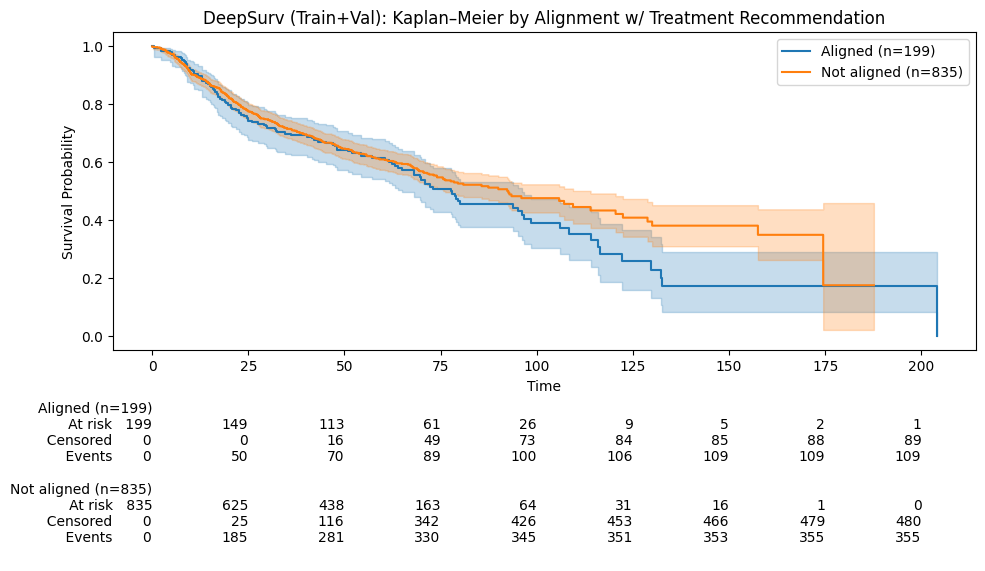

[DeepSurv (Train+Val)] Log-rank p-value: 0.162069
[DeepSurv (Train+Val)] Recommend ACT rate: 0.953
[DeepSurv (Train+Val)] Alignment rate:     0.192


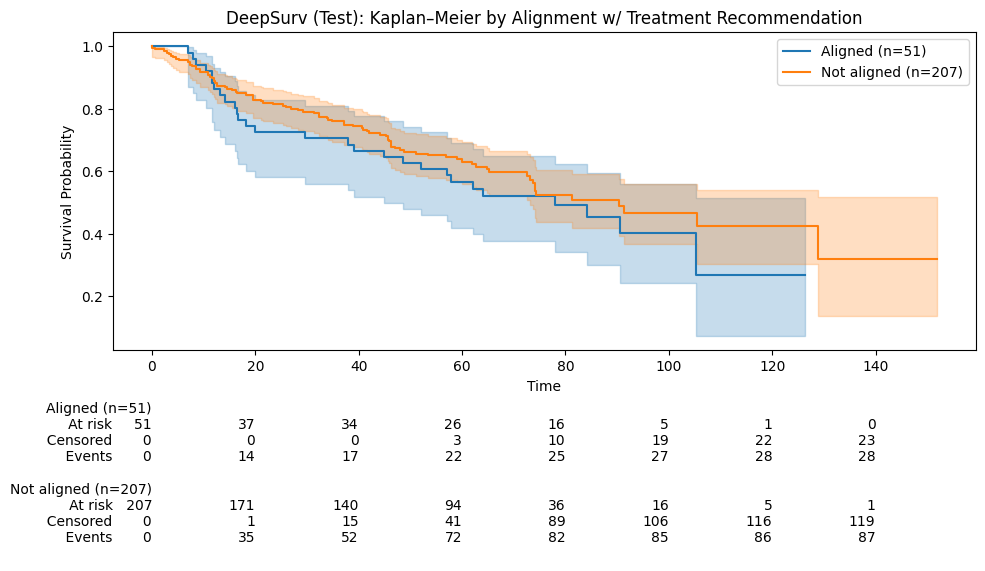

[DeepSurv (Test)] Log-rank p-value: 0.337785
[DeepSurv (Test)] Recommend ACT rate: 0.950
[DeepSurv (Test)] Alignment rate:     0.198


In [ ]:
# ============================================================
# Colab-ready SINGLE CELL
# Run-only: load deepsurv_best.pt + features_used.txt + chosen_params.txt
# Rebuild features, refit imputer+scaler on Train+Val, evaluate Train+Val + Test
# + Kaplan–Meier comparison: aligned with model treatment recommendation vs not
# ============================================================

# ---------- installs ----------
!pip -q install lifelines scikit-survival

import os, ast, random, warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

warnings.filterwarnings("ignore", message="Ties in event time detected; using efron's method to handle ties.")
torch.manual_seed(0); np.random.seed(0); random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Paths (EDIT IF NEEDED)
# ---------------------------
TRAIN_CSV = "/content/drive/MyDrive/affyfRMATrain.csv"
VALID_CSV = "/content/drive/MyDrive/affyfRMAValidation.csv"
TEST_CSV  = "/content/drive/MyDrive/affyfRMATest.csv"

OUT_DIR = "/content/drive/MyDrive/deepsurv_results_optuna_interactions_iptw_bounded"
MODEL_PT  = os.path.join(OUT_DIR, "deepsurv_best.pt")
FEATS_TXT = os.path.join(OUT_DIR, "features_used.txt")
PARAMS_TXT= os.path.join(OUT_DIR, "chosen_params.txt")

assert os.path.exists(TRAIN_CSV), f"Missing: {TRAIN_CSV}"
assert os.path.exists(VALID_CSV), f"Missing: {VALID_CSV}"
assert os.path.exists(TEST_CSV),  f"Missing: {TEST_CSV}"
assert os.path.exists(MODEL_PT),  f"Missing model: {MODEL_PT}"
assert os.path.exists(FEATS_TXT), f"Missing features_used.txt: {FEATS_TXT}"
assert os.path.exists(PARAMS_TXT),f"Missing chosen_params.txt: {PARAMS_TXT}"

# ---------------------------
# Helpers
# ---------------------------
def parse_params_txt(path):
    s = open(path, "r").read().strip()
    try:
        d = ast.literal_eval(s)
        if isinstance(d, dict):
            return d
    except Exception:
        pass
    i, j = s.find("{"), s.rfind("}")
    if i != -1 and j != -1:
        d = ast.literal_eval(s[i:j+1])
        if isinstance(d, dict):
            return d
    raise ValueError("Could not parse chosen_params.txt as a python dict string.")

def layers_from_arch(arch_str: str):
    return [int(x) for x in str(arch_str).split("-") if x.strip()]

def coerce_survival_cols(df):
    if "OS_STATUS" not in df.columns or "OS_MONTHS" not in df.columns:
        raise KeyError("Expected survival columns OS_STATUS and OS_MONTHS.")
    if df["OS_STATUS"].dtype == object:
        df["OS_STATUS"] = df["OS_STATUS"].replace({"DECEASED":1,"LIVING":0,"Dead":1,"Alive":0}).astype(int)
    else:
        df["OS_STATUS"] = pd.to_numeric(df["OS_STATUS"], errors="coerce").fillna(0).astype(int)
    df["OS_MONTHS"] = pd.to_numeric(df["OS_MONTHS"], errors="coerce").fillna(0.0).astype(float)
    return df

def coerce_act(df, act_col="Adjuvant Chemo"):
    if act_col not in df.columns:
        raise KeyError(f"Expected treatment column '{act_col}'.")
    df[act_col] = df[act_col].replace({"OBS":0, "ACT":1})
    df[act_col] = pd.to_numeric(df[act_col], errors="coerce").fillna(0).astype(int)
    return df

def load_features_list(path):
    feats = [ln.strip() for ln in open(path, "r").read().splitlines() if ln.strip()]
    if not feats:
        raise ValueError("features_used.txt is empty.")
    return feats

def build_X_from_features(df, features_used, act_col="Adjuvant Chemo"):
    """
    Build X in exact order of features_used.
    Supports interaction columns like 'TP53*ACT' = TP53 * Adjuvant Chemo.
    """
    missing = []
    if act_col not in df.columns and any(f.endswith("*ACT") for f in features_used):
        missing.append(act_col)

    for f in features_used:
        if f.endswith("*ACT"):
            gene = f[:-4]
            if gene not in df.columns:
                missing.append(gene)
        else:
            if f not in df.columns:
                missing.append(f)

    if missing:
        raise KeyError(f"Missing required columns: {sorted(set(missing))[:50]}")

    cols = []
    A = df[act_col].to_numpy(dtype=np.float32)
    for f in features_used:
        if f.endswith("*ACT"):
            gene = f[:-4]
            cols.append((df[gene].to_numpy(dtype=np.float32) * A).reshape(-1, 1))
        else:
            cols.append(df[[f]].to_numpy(dtype=np.float32))
    X = np.concatenate(cols, axis=1).astype(np.float32)
    return X

def build_X_from_features_with_forced_act(df, features_used, act_value, med, scaler, act_col="Adjuvant Chemo"):
    df2 = df.copy()
    df2[act_col] = int(act_value)
    X_raw = build_X_from_features(df2, features_used, act_col=act_col)
    X_imp = np.where(np.isnan(X_raw), med, X_raw)
    X_sc  = scaler.transform(X_imp).astype(np.float32)
    return X_sc

class DeepSurvMLP(nn.Module):
    def __init__(self, in_features, hidden_layers, dropout=0.0, activation=nn.ReLU()):
        super().__init__()
        layers, d = [], in_features
        for units in hidden_layers:
            layers += [nn.Linear(d, units), activation]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = units
        layers.append(nn.Linear(d, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

class SurvivalDataset(Dataset):
    def __init__(self, X, t, e):
        self.x = torch.tensor(X, dtype=torch.float32)
        self.t = torch.tensor(t, dtype=torch.float32)
        self.e = torch.tensor(e.astype(bool), dtype=torch.bool)
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.t[idx], self.e[idx]

@torch.no_grad()
def deepsurv_predict_risk(model, X_np):
    model.eval()
    x = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.clamp(model(x), -20, 20).detach().cpu().numpy().ravel()
    return y  # higher => higher risk

@torch.no_grad()
def evaluate_ci(model, dataloader):
    model.eval()
    preds, times, events = [], [], []
    for x, t, e in dataloader:
        y = torch.clamp(model(x.to(device)), -20, 20).cpu().numpy().ravel()
        preds.append(y); times.append(t.numpy()); events.append(e.numpy())
    preds = np.concatenate(preds)
    times = np.concatenate(times)
    events = np.concatenate(events).astype(bool)
    return float(concordance_index_censored(events, times, preds)[0])

@torch.no_grad()
def evaluate_ci_grouped(model, X, t, e, group_mask):
    model.eval()
    preds = model(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().ravel()
    out = {}
    for label, mask in [("ACT=1", group_mask.astype(bool)), ("ACT=0", ~group_mask.astype(bool))]:
        if mask.sum() >= 3:
            out[label] = float(concordance_index_censored(e[mask].astype(bool), t[mask], preds[mask])[0])
        else:
            out[label] = float("nan")
    return out

def compare_treatment_recommendation_km_deepsurv(model, df, features_used, med, scaler,
                                                time_col="OS_MONTHS", event_col="OS_STATUS",
                                                act_col="Adjuvant Chemo", title_prefix="DeepSurv"):
    """
    Compare survival outcomes based on alignment with the DeepSurv model's treatment recommendation.
    Recommendation: ACT if predicted risk(ACT=1) < predicted risk(ACT=0).
    """
    df = df.copy()
    df = coerce_act(df, act_col)
    df = coerce_survival_cols(df)
    df[act_col] = df[act_col].astype(int)

    X_act1 = build_X_from_features_with_forced_act(df, features_used, 1, med, scaler, act_col=act_col)
    X_act0 = build_X_from_features_with_forced_act(df, features_used, 0, med, scaler, act_col=act_col)

    risk_act1 = deepsurv_predict_risk(model, X_act1)
    risk_act0 = deepsurv_predict_risk(model, X_act0)

    model_rec = (risk_act1 < risk_act0).astype(int)
    actual = df[act_col].to_numpy(int)
    aligned = (actual == model_rec)

    df["model_rec"] = model_rec
    df["alignment"] = aligned

    mask_aligned = df["alignment"] == True
    mask_not = df["alignment"] == False

    if mask_aligned.sum() < 3 or mask_not.sum() < 3:
        print(f"[{title_prefix}] Not enough samples to plot KM (aligned={mask_aligned.sum()}, not_aligned={mask_not.sum()}).")
        return df

    res = logrank_test(
        df.loc[mask_aligned, time_col],
        df.loc[mask_not, time_col],
        event_observed_A=df.loc[mask_aligned, event_col],
        event_observed_B=df.loc[mask_not, event_col],
    )

    kmf_a = KaplanMeierFitter()
    kmf_n = KaplanMeierFitter()

    plt.figure(figsize=(10, 6))
    kmf_a.fit(df.loc[mask_aligned, time_col],
              event_observed=df.loc[mask_aligned, event_col],
              label=f"Aligned (n={mask_aligned.sum()})")
    ax = kmf_a.plot(ci_show=True)

    kmf_n.fit(df.loc[mask_not, time_col],
              event_observed=df.loc[mask_not, event_col],
              label=f"Not aligned (n={mask_not.sum()})")
    kmf_n.plot(ax=ax, ci_show=True)

    plt.title(f"{title_prefix}: Kaplan–Meier by Alignment w/ Treatment Recommendation")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    add_at_risk_counts(kmf_a, kmf_n)
    plt.text(0.1, 0.1, f"p = {res.p_value:.3f}", transform=ax.transAxes)
    plt.tight_layout()
    plt.show()


    print(f"[{title_prefix}] Log-rank p-value: {float(res.p_value):.6g}")
    print(f"[{title_prefix}] Recommend ACT rate: {df['model_rec'].mean():.3f}")
    print(f"[{title_prefix}] Alignment rate:     {df['alignment'].mean():.3f}")
    return df

# ---------------------------
# Load artifacts
# ---------------------------
chosen_params = parse_params_txt(PARAMS_TXT)
features_used = load_features_list(FEATS_TXT)

arch = chosen_params.get("arch", "64-32")
dropout = float(chosen_params.get("dropout", 0.0))
batch_size = int(chosen_params.get("batch_size", 128))

hidden_layers = layers_from_arch(arch)
in_dim = len(features_used)

print(f"[Artifacts] arch={arch} layers={hidden_layers} dropout={dropout} batch_size={batch_size}")
print(f"[Artifacts] n_features={in_dim} (from features_used.txt)")

# ---------------------------
# Load data
# ---------------------------
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df = coerce_survival_cols(coerce_act(train_df))
valid_df = coerce_survival_cols(coerce_act(valid_df))
test_df  = coerce_survival_cols(coerce_act(test_df))

trainval_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
trainval_df = trainval_df.sort_values(by=["OS_MONTHS","OS_STATUS"], ascending=[False, False]).reset_index(drop=True)

# ---------------------------
# Build X matrices exactly from features_used.txt
# ---------------------------
X_trv_raw = build_X_from_features(trainval_df, features_used)
X_te_raw  = build_X_from_features(test_df,      features_used)

# Train+Val fit imputer + scaler (since not persisted)
med = np.nanmedian(X_trv_raw, axis=0)
X_trv = np.where(np.isnan(X_trv_raw), med, X_trv_raw)
X_te  = np.where(np.isnan(X_te_raw),  med, X_te_raw)

scaler = StandardScaler().fit(X_trv)
X_trv = scaler.transform(X_trv).astype(np.float32)
X_te  = scaler.transform(X_te).astype(np.float32)

y_trv_t = trainval_df["OS_MONTHS"].to_numpy(np.float32)
y_trv_e = trainval_df["OS_STATUS"].to_numpy(int)
y_te_t  = test_df["OS_MONTHS"].to_numpy(np.float32)
y_te_e  = test_df["OS_STATUS"].to_numpy(int)

# ---------------------------
# Load model weights
# ---------------------------
model = DeepSurvMLP(in_dim, hidden_layers, dropout=dropout).to(device)
state = torch.load(MODEL_PT, map_location=device)
model.load_state_dict(state)
model.eval()
print("[Model] Loaded weights from:", MODEL_PT)

# ---------------------------
# Evaluate C-index
# ---------------------------
dl_trv = DataLoader(SurvivalDataset(X_trv, y_trv_t, y_trv_e), batch_size=batch_size, shuffle=False, num_workers=0)
dl_te  = DataLoader(SurvivalDataset(X_te,  y_te_t,  y_te_e),  batch_size=batch_size, shuffle=False, num_workers=0)

trainval_ci = evaluate_ci(model, dl_trv)
test_ci = evaluate_ci(model, dl_te)

print(f"\n[Run-only] Train+Val CI: {trainval_ci:.4f}")
print(f"[Run-only] Test CI:      {test_ci:.4f}")

act_trv = trainval_df["Adjuvant Chemo"].to_numpy(int)
act_te  = test_df["Adjuvant Chemo"].to_numpy(int)
print("[Train+Val] CI by arm:", evaluate_ci_grouped(model, X_trv, y_trv_t, y_trv_e, act_trv == 1))
print("[Test]      CI by arm:", evaluate_ci_grouped(model, X_te,  y_te_t,  y_te_e,  act_te == 1))

# ---------------------------
# Kaplan–Meier: aligned vs not aligned with model recommendation
# ---------------------------
_ = compare_treatment_recommendation_km_deepsurv(
    model, trainval_df, features_used, med, scaler,
    time_col="OS_MONTHS", event_col="OS_STATUS", act_col="Adjuvant Chemo",
    title_prefix="DeepSurv (Train+Val)"
)

_ = compare_treatment_recommendation_km_deepsurv(
    model, test_df, features_used, med, scaler,
    time_col="OS_MONTHS", event_col="OS_STATUS", act_col="Adjuvant Chemo",
    title_prefix="DeepSurv (Test)"
)